In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


In [2]:
# Set parameter
nb_batch = 128
num_classes = 100
nb_epochs = 200
dropout_rate = 0.3
learning_rate = 1e-3

In [3]:
# Set save model info
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

In [4]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data('fine')
print('x_train shape:', x_train.shape)
print('x_train dtype:', x_train.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
x_train dtype: uint8
50000 train samples
10000 test samples


## Label class

y_test value : 0 ~ 99

In [5]:
print('Label class:\n', np.unique(y_test))
class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly',
               'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
               'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
               'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
               'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum',
               'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
               'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
               'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
               'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

Label class:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


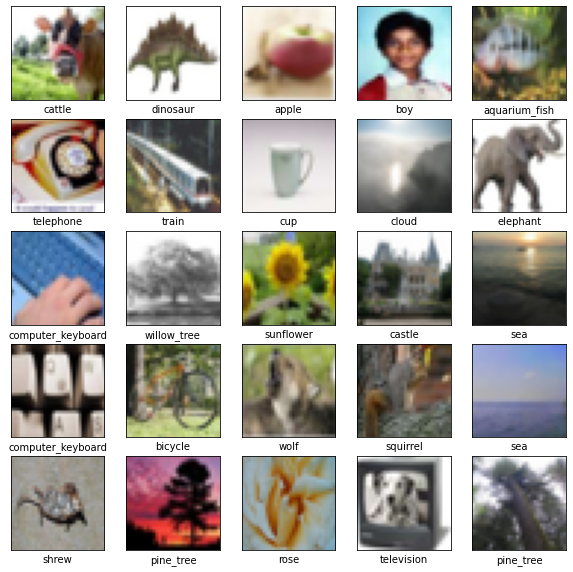

In [6]:
# 학습 이미지 확인
plt.figure(figsize=(10, 10), facecolor='white')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [7]:
# 전처리
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
data_augmentation_layer = Sequential([
                            keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                            keras.layers.experimental.preprocessing.RandomRotation(0.05)
                        ])

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(nb_batch)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)


In [8]:
# 전처리
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)

In [9]:
IMG_SIZE = 96

base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        weights='imagenet',
                        include_top=False)
base_model.trainable = False

model = Sequential()
model.add(keras.layers.Resizing(IMG_SIZE, IMG_SIZE, input_shape=x_train.shape[1:]))
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

In [10]:
print("Number of layers in the base model: ", len(base_model.layers))
model.summary()

Number of layers in the base model:  190
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
Total params: 25,765,476
Trainable params: 2,200,676
Non-trainable params: 23,5

In [11]:
# Compile
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

In [12]:
# Restore weights
if os.path.isfile(model_path):
    # model.load_weights(model_path)
    # print('Weights load success.')
    pass

# Set callbacks
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=model_path, save_weights_only=True)

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                         monitor='val_loss')

lr_reducer = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                               cooldown=0,
                               patience=5,
                               min_lr=0.1e-6)

In [13]:
hist = model.fit(train_ds, batch_size=nb_batch, epochs=nb_epochs,
                 verbose=1, validation_data=test_ds,
                 shuffle=True,
                 callbacks=[checkpointer, callback, lr_reducer])

Epoch 1/200
391/391 [==============================] - 30s 66ms/step - loss: 2.6614 - accuracy: 0.3468 - val_loss: 2.0127 - val_accuracy: 0.4609
Epoch 2/200
391/391 [==============================] - 24s 62ms/step - loss: 2.1194 - accuracy: 0.4430 - val_loss: 1.9039 - val_accuracy: 0.4849
Epoch 3/200
391/391 [==============================] - 25s 63ms/step - loss: 1.9469 - accuracy: 0.4776 - val_loss: 1.8675 - val_accuracy: 0.4943
Epoch 4/200
391/391 [==============================] - 25s 63ms/step - loss: 1.8370 - accuracy: 0.4999 - val_loss: 1.8521 - val_accuracy: 0.5007
Epoch 5/200
391/391 [==============================] - 25s 63ms/step - loss: 1.7474 - accuracy: 0.5217 - val_loss: 1.8712 - val_accuracy: 0.5037
Epoch 6/200
391/391 [==============================] - 25s 64ms/step - loss: 1.6766 - accuracy: 0.5367 - val_loss: 1.8649 - val_accuracy: 0.5097
Epoch 7/200
391/391 [==============================] - 24s 62ms/step - loss: 1.6057 - accuracy: 0.5555 - val_loss: 1.8726 - val_ac

In [14]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest accuracy: {:.2f}%'.format(test_acc * 100))

79/79 - 4s - loss: 1.7586 - accuracy: 0.5535

Test accuracy: 55.35%


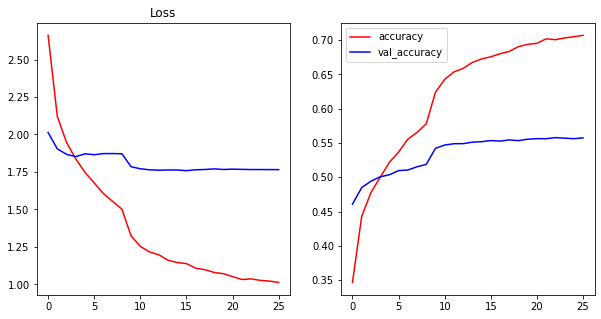

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'r-', label='loss')
plt.plot(hist.history['val_loss'], 'b-', label='val_loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], 'r-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', label='val_accuracy')
plt.legend()
plt.show()


In [16]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate / 10.0),
              metrics=['accuracy'])

model.summary()

print('Trainable params:', len(model.trainable_variables))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
Total params: 25,765,476
Trainable params: 22,760,548
Non-trainable params: 3,004,928
__________________________________

In [17]:
pre_train_epochs = hist.epoch[-1]
fine_tune_epochs = 50
total_epochs = pre_train_epochs + fine_tune_epochs

hist_fine = model.fit(train_ds, batch_size=nb_batch, epochs=total_epochs,
                      initial_epoch=hist.epoch[-1],
                      verbose=1, validation_data=test_ds,
                      shuffle=True,
                      callbacks=[checkpointer, callback, lr_reducer])

Epoch 26/75
391/391 [==============================] - 48s 114ms/step - loss: 1.6007 - accuracy: 0.5607 - val_loss: 1.4285 - val_accuracy: 0.6054
Epoch 27/75
391/391 [==============================] - 44s 111ms/step - loss: 1.1052 - accuracy: 0.6798 - val_loss: 1.3488 - val_accuracy: 0.6353
Epoch 28/75
391/391 [==============================] - 44s 111ms/step - loss: 0.9002 - accuracy: 0.7314 - val_loss: 1.2914 - val_accuracy: 0.6515
Epoch 29/75
391/391 [==============================] - 44s 111ms/step - loss: 0.7432 - accuracy: 0.7721 - val_loss: 1.2932 - val_accuracy: 0.6569
Epoch 30/75
391/391 [==============================] - 44s 111ms/step - loss: 0.6299 - accuracy: 0.8070 - val_loss: 1.2795 - val_accuracy: 0.6683
Epoch 31/75
391/391 [==============================] - 44s 111ms/step - loss: 0.5388 - accuracy: 0.8337 - val_loss: 1.2826 - val_accuracy: 0.6689
Epoch 32/75
391/391 [==============================] - 44s 111ms/step - loss: 0.4602 - accuracy: 0.8578 - val_loss: 1.2997 -

79/79 - 4s - loss: 1.2795 - accuracy: 0.6683
Test accuracy: 55.35%
Fine tune test accuracy: 66.83%


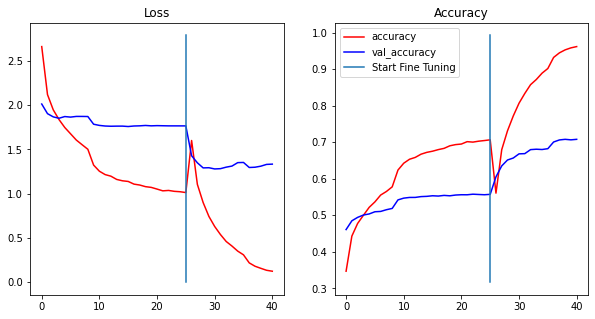

In [18]:
fine_test_loss, fine_test_acc = model.evaluate(test_ds, verbose=2)
print('Test accuracy: {:.2f}%'.format(test_acc * 100))
print('Fine tune test accuracy: {:.2f}%'.format(fine_test_acc * 100))

acc = hist.history['accuracy'] + hist_fine.history['accuracy']
val_acc = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, 'r-', label='loss')
plt.plot(val_loss, 'b-', label='val_loss')
plt.plot([pre_train_epochs, pre_train_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc, 'r-', label='accuracy')
plt.plot(val_acc, 'b-', label='val_accuracy')
plt.plot([pre_train_epochs, pre_train_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Accuracy')
plt.show()


In [19]:
# 학습 결과 테스트를 이미지화 함수
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

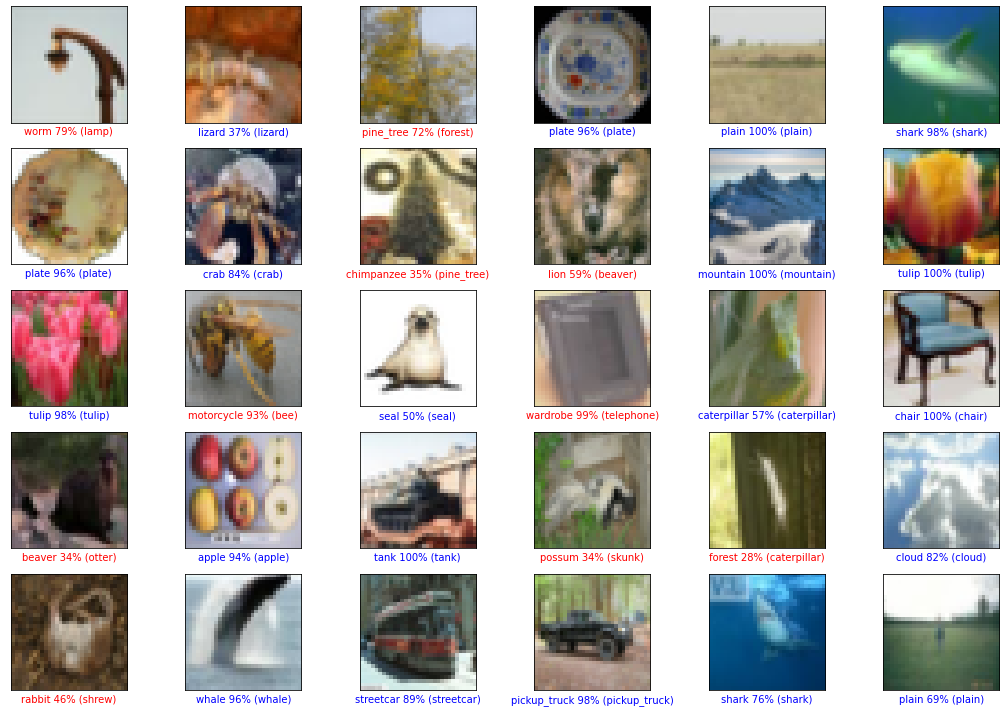

In [20]:
# 예측 결과 이미지화
test_iter = iter(test_ds.shuffle(nb_batch))
num_rows = 5
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(15, 10), facecolor='white')

test_img_list, test_label_list = next(test_iter)

# Test 이미지 예측
predictions = model.predict(test_img_list)

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(i, predictions[i], test_label_list, test_img_list)
plt.tight_layout()
plt.show()
